In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers.pooling import MaxPooling2D
import tensorflow as tf
from tensorflow import keras
import keras.layers
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Dropout, Normalization,MaxPool2D,Flatten
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3940352/45929032 bytes (8.6%)7634944/45929032 bytes (16.6%)11591680/45929032 bytes (25.2%)15425536/45929032 bytes (33.6%)19382272/45929032 bytes (42.2%)20447232/45929032 bytes (44.5%)24576000/45929032 bytes (53.5%)28614656/45929032 bytes (62.3%)32841728/45929032 bytes (71.5%)36741120/45929032 bytes (80.0%)40779776/45929032 bytes (88.8%)44793856/45929032 bytes (97.5%)

# Data

In [ ]:
!wget http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
!wget http://www.robots.ox.ac.uk/~alonso/data/readme.txt
!mkdir TV-HI
!tar -xvf  'tv_human_interactions_videos.tar.gz' -C TV-HI
!mv readme.txt 'TV-HI/readme.txt'

In [ ]:
set_1_indices = [[2,14,15,16,18,19,20,21,24,25,26,27,28,32,40,41,42,43,44,45,46,47,48,49,50],
                 [1,6,7,8,9,10,11,12,13,23,24,25,27,28,29,30,31,32,33,34,35,44,45,47,48],
                 [2,3,4,11,12,15,16,17,18,20,21,27,29,30,31,32,33,34,35,36,42,44,46,49,50],
                 [1,7,8,9,10,11,12,13,14,16,17,18,22,23,24,26,29,31,35,36,38,39,40,41,42]]
set_2_indices = [[1,3,4,5,6,7,8,9,10,11,12,13,17,22,23,29,30,31,33,34,35,36,37,38,39],
                 [2,3,4,5,14,15,16,17,18,19,20,21,22,26,36,37,38,39,40,41,42,43,46,49,50],
                 [1,5,6,7,8,9,10,13,14,19,22,23,24,25,26,28,37,38,39,40,41,43,45,47,48],
                 [2,3,4,5,6,15,19,20,21,25,27,28,30,32,33,34,37,43,44,45,46,47,48,49,50]]
classes = ['handShake', 'highFive', 'hug', 'kiss']  # we ignore the negative class

# test set
set_1 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_1_indices[c]]
set_1_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_1_indices[c]]
print(f'Set 1 to be used for test ({len(set_1)}):\n\t{set_1}')
print(f'Set 1 labels ({len(set_1_label)}):\n\t{set_1_label}\n')

# training set
set_2 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_2_indices[c]]
set_2_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_2_indices[c]]
print(f'Set 2 to be used for train and validation ({len(set_2)}):\n\t{set_2}')
print(f'Set 2 labels ({len(set_2_label)}):\n\t{set_2_label}')


Set 1 to be used for test (100):
	['handShake_0002.avi', 'handShake_0014.avi', 'handShake_0015.avi', 'handShake_0016.avi', 'handShake_0018.avi', 'handShake_0019.avi', 'handShake_0020.avi', 'handShake_0021.avi', 'handShake_0024.avi', 'handShake_0025.avi', 'handShake_0026.avi', 'handShake_0027.avi', 'handShake_0028.avi', 'handShake_0032.avi', 'handShake_0040.avi', 'handShake_0041.avi', 'handShake_0042.avi', 'handShake_0043.avi', 'handShake_0044.avi', 'handShake_0045.avi', 'handShake_0046.avi', 'handShake_0047.avi', 'handShake_0048.avi', 'handShake_0049.avi', 'handShake_0050.avi', 'highFive_0001.avi', 'highFive_0006.avi', 'highFive_0007.avi', 'highFive_0008.avi', 'highFive_0009.avi', 'highFive_0010.avi', 'highFive_0011.avi', 'highFive_0012.avi', 'highFive_0013.avi', 'highFive_0023.avi', 'highFive_0024.avi', 'highFive_0025.avi', 'highFive_0027.avi', 'highFive_0028.avi', 'highFive_0029.avi', 'highFive_0030.avi', 'highFive_0031.avi', 'highFive_0032.avi', 'highFive_0033.avi', 'highFive_0034.a

In [ ]:
# convert train labels into integers
training_label_int = []
for label in set_1_label:
  training_label_int.append(set_2_label.index(label))
training_labels = np.array(training_label_int)

# convert test labels into integers
testing_label_int = []
for label in set_2_label:
  testing_label_int.append(set_1_label.index(label))
testing_labels = np.array(testing_label_int)


In [ ]:
# OHE Labels
labels_train = []
for label in training_labels:
  if label == 0:
    labels_train.append(np.array([1,0,0,0]))
  elif label == 25:
    labels_train.append(np.array([0,1,0,0]))
  elif label == 50:
    labels_train.append(np.array([0,0,1,0]))
  elif label == 75:
    labels_train.append(np.array([0,0,0,1]))
  
labels_test = []
for label in testing_labels:
  if label == 0:
    labels_test.append(np.array([1,0,0,0]))
  elif label == 25:
    labels_test.append(np.array([0,1,0,0]))
  elif label == 50:
    labels_test.append(np.array([0,0,1,0]))
  elif label == 75:
    labels_test.append(np.array([0,0,0,1]))

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)



In [ ]:
# Compute middle frame for Optical Flow

frames_total = []

for x in range(100):                                                                              #Iterate over all 100 videos...
  clip=VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_1[x]}')                            #...extract xth clip...
  number_of_frames = 0                                                                            #...(re-)initialise number of frames (int)
  for frame in clip.iter_frames():                                                                #.Count number of frames...
    number_of_frames+=1
  middle_frame_position = int(number_of_frames/2)
  frames_total.append(middle_frame_position)   

In [ ]:
#Optical flow
all_flows=[]
for i in range(100):                                                        #iterate through clips
  clip = VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_1[i]}')    #current clip
  int_mf = frames_total[i]                                                  #get int middle frame
  frames = []
  for f,frame in enumerate(clip.iter_frames()):
    if f >= int_mf and f < int_mf+12:                                       #Collect 16 frames, measured from the middle frame onward
      frames.append(frame)
    if f == int_mf+12:
      break                                                                 #If frames are collected, dont stop looping through remaining frames

  prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)                  #Init previous frame, read in grayscale, resize (because all clips can have somewhat different shapes)
  prev_frame = cv2.resize(prev_frame, (30,40))     

  flows = []
  for frame_int in range(1,12):
    curr_frame = cv2.cvtColor(frames[frame_int], cv2.COLOR_BGR2GRAY)        #Read current frame in grayscale, resize
    curr_frame = cv2.resize(curr_frame, (30,40))

    flow = cv2.calcOpticalFlowFarneback(prev_frame,curr_frame, None, 0.5, 3, 15, 3, 7, 1.2, 0) 
                              #Compute optical flow, convert to colors to see optical flow in colors (which aids learning)

    np.reshape(flow, (30,40,2))
    flows.append(flow)                                                       #Save this image's opticical flow
    prev_frame = curr_frame
  
  stack = np.stack(flows,axis=2)                                                  #Create single stack of images and save it: before hstack(flows)
  all_flows.append(stack)                                                 #Create single stack of images and save it
 


In [ ]:
#Train Validation split
#shape (176, 3432, 2)
train_images_new=[];validation_images_new=[];train_labels_new=[]; validation_labels_new =[] 
for x in range(0,100,10):
  train_images_new.append(all_flows[x:x+9])        #append index 0 up until 9 to training...
  validation_images_new.append(all_flows[x+9])     #...append index 9 to validation

  train_labels_new.append(labels_train[x:x+9])
  validation_labels_new.append(labels_train[x+9])


of_train_labels = np.array(train_labels_new); of_train_images=np.array(train_images_new)

of_validation_labels = np.array(validation_labels_new); of_validation_images = np.array(validation_images_new)
del train_images_new,train_labels_new,validation_images_new,validation_labels_new               #Del temporary variables


In [ ]:
print(of_train_images.shape, "", of_train_labels.shape, "", of_validation_images.shape, "", of_validation_labels.shape)

(10, 9, 40, 30, 11, 2)  (10, 9, 4)  (10, 40, 30, 11, 2)  (10, 4)


In [ ]:
of_train_images = np.reshape(of_train_images, (90,40,30,22))
of_train_labels = np.reshape(of_train_labels,(90, 4))
of_validation_images = np.reshape(of_validation_images, (10,40,30,22))

In [ ]:
print(of_train_images.shape, "", of_train_labels.shape, "", of_validation_images.shape, "", of_validation_labels.shape)

(90, 40, 30, 22)  (90, 4)  (10, 40, 30, 22)  (10, 4)


Model2 TF

In [ ]:
# Get the middle frame of each train video:
training_images_fromvideo = []
for x in range(100):
  clip=VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_1[x]}')
  frame = clip.get_frame(clip.duration/2)
  #image = tf.image.convert_image_dtype(frame, tf.float32) # equivalent to dividing image pixels by 255
  image = tf.image.resize(frame, (40,30))
  training_images_fromvideo.append(image)
training_images_fromvideo = np.array(training_images_fromvideo)
training_images_fromvideo = training_images_fromvideo.astype('float32')

In [ ]:
train_images_new=[]; validation_images_new=[]; train_labels_new=[]; validation_labels_new =[]   #Temporary variables

for x in range(0,100,10):
  #print(x,":",x+9)
  train_images_new.append(training_images_fromvideo[x:x+9])        #append index 0 up until 9 to training...
  train_labels_new.append(labels_train[x:x+9])
  
  #print("x:",x+9)
  validation_images_new.append(training_images_fromvideo[x+9])     #...append index 9 to validation
  validation_labels_new.append(labels_train[x+9])


tf_train_labels = np.array(train_labels_new); tf_train_images=np.array(train_images_new)
tf_validation_labels = np.array(validation_labels_new); tf_validation_images = np.array(validation_images_new)
del train_images_new,train_labels_new,validation_images_new,validation_labels_new               #Del temporary variables
print("train_images: ", tf_train_images.shape, "train_labels: ", tf_train_labels.shape,"validation_labels: ", tf_validation_labels.shape, "validation_images: ", tf_validation_images.shape)

train_images:  (10, 9, 40, 30, 3) train_labels:  (10, 9, 4) validation_labels:  (10, 4) validation_images:  (10, 40, 30, 3)


In [ ]:
tf_train_images = np.reshape(tf_train_images, (90,40,30,3))
tf_train_labels = np.reshape(tf_train_labels,(90, 4))
print(tf_train_images.shape, "", tf_train_labels.shape, "", tf_validation_images.shape, "", tf_validation_labels.shape)

(90, 40, 30, 3)  (90, 4)  (10, 40, 30, 3)  (10, 4)


# Pretrained Models
Import both Pretrained Model and freeze the weights so that they cant get updated

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Open both Models

#TRANSFERED MODEL
tf_model = keras.models.load_model("/content/drive/MyDrive/Assignment5/Model_for_TVHITransferLearning5.2")
tf_model = tf.keras.Model(inputs=tf_model.input, outputs=tf_model.layers[-2].output, name="TF-Model")
#transfered_learned_model.trainable = False # prevents the weights in a given layer from being updated during training
tf_model.summary()

#OPTICAL FLOW
of_model = keras.models.load_model("/content/drive/MyDrive/Assignment5/Model_opticalFlow")
of_model = tf.keras.Model(inputs=of_model.input, outputs=of_model.layers[-2].output, name="OF-Model")
#of_model.trainable = False # prevents the weights in a given layer from being updated during training
of_model.summary()

Model: "TF-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 40, 30, 3)]       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 40, 30, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 40, 30, 3)         0         
                                                                 
 model_17 (Functional)       (None, 160)               438400    
                                                                 
 dense_30 (Dense)            (None, 512)               82432     
                                                                 
Total params: 520,832
Trainable params: 520,832
Non-trainable params: 0
_________________________________________________________________
Model: "OF-Model"
__________________________________

# New two-stream Model


In [ ]:
# New Model (Instead of Sequential we use functional API)

input_tf_model = tf.keras.Input(shape=(40, 30, 3))
input_of_model = tf.keras.Input(shape=(40, 30, 22))

transfered_features = tf_model(input_tf_model, training=True)
of_features = of_model(input_of_model, training=True)

#Concatenate both models
x = layers.concatenate([transfered_features, of_features])
#x = tf.keras.layers.GlobalAveragePooling2D()(x) # addintionaly flattens the input 
x = layers.Dense(64, activation='relu', kernel_regularizer='l1_l2')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer='l1_l2')(x)

outputs = Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=[input_tf_model, input_of_model], outputs=outputs, name="2stream_model")
model.summary()

Model: "2stream_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 40, 30, 3)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 40, 30, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 TF-Model (Functional)          (None, 512)          520832      ['input_7[0][0]']                
                                                                                                  
 OF-Model (Functional)          (None, 512)          11568960    ['input_8[0][0]']    

In [ ]:

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
print("tf_train_images: ", tf_train_images.shape, "tf_train_labels: ", tf_train_labels.shape,"tf_validation_labels: ", tf_validation_labels.shape, "validation_images: ", tf_validation_images.shape)

tf_train_images:  (90, 40, 30, 3) tf_train_labels:  (90, 4) tf_validation_labels:  (10, 4) validation_images:  (10, 40, 30, 3)


In [ ]:
print("tf_train_images: ", of_train_images.shape, "of_train_labels: ", of_train_labels.shape,"of_validation_labels: ", of_validation_labels.shape, "validation_images: ", of_validation_images.shape)

tf_train_images:  (90, 40, 30, 22) of_train_labels:  (90, 4) of_validation_labels:  (10, 4) validation_images:  (10, 40, 30, 22)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=.001),metrics=['accuracy'],loss='categorical_crossentropy')
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(x=[tf_train_images, of_train_images], y=tf_train_labels, validation_data=([tf_validation_images, of_validation_images], tf_validation_labels), epochs=30, batch_size=10, callbacks=[callback])

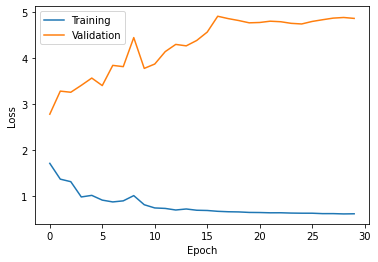

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

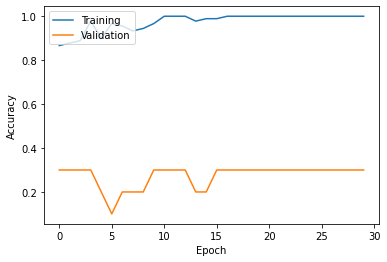

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Assignment5/Two-Stream-Model")

ValueError: ignored

In [ ]:
# Get the middle frame of each train video:
training_images_fromvideo = []
for x in range(100):
  clip=VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_2[x]}')
  frame = clip.get_frame(clip.duration/2)
  #image = tf.image.convert_image_dtype(frame, tf.float32) # equivalent to dividing image pixels by 255
  image = tf.image.resize(frame, (40,30))
  training_images_fromvideo.append(image)
training_images_fromvideo = np.array(training_images_fromvideo)
training_images_fromvideo = training_images_fromvideo.astype('float32')

# Compute middle frame for Optical Flow

frames_total_test = []

for x in range(100):                                                                              #Iterate over all 100 videos...
  clip=VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_2[x]}')                            #...extract xth clip...
  number_of_frames = 0                                                                            #...(re-)initialise number of frames (int)
  for frame in clip.iter_frames():                                                                #.Count number of frames...
    number_of_frames+=1
  middle_frame_position = int(number_of_frames/2)
  frames_total_test.append(middle_frame_position)   


#Optical flow
all_flows_test=[]
for i in range(100):                                                        #iterate through clips
  clip = VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_2[i]}')    #current clip
  int_mf = frames_total_test[i]                                                  #get int middle frame
  frames = []
  for f,frame in enumerate(clip.iter_frames()):
    if f >= int_mf and f < int_mf+12:                                       #Collect 16 frames, measured from the middle frame onward
      frames.append(frame)
    if f == int_mf+12:
      break                                                                 #If frames are collected, dont stop looping through remaining frames

  prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)                  #Init previous frame, read in grayscale, resize (because all clips can have somewhat different shapes)
  prev_frame = cv2.resize(prev_frame, (30,40))     

  flows = []
  for frame_int in range(1,12):
    curr_frame = cv2.cvtColor(frames[frame_int], cv2.COLOR_BGR2GRAY)        #Read current frame in grayscale, resize
    curr_frame = cv2.resize(curr_frame, (30,40))

    flow = cv2.calcOpticalFlowFarneback(prev_frame,curr_frame, None, 0.5, 3, 15, 3, 7, 1.2, 0) 
                              #Compute optical flow, convert to colors to see optical flow in colors (which aids learning)

    np.reshape(flow, (30,40,2))
    flows.append(flow)                                                       #Save this image's opticical flow
    prev_frame = curr_frame
  
  stack = np.stack(flows,axis=2)                                                  #Create single stack of images and save it: before hstack(flows)
  all_flows_test.append(stack)                                                 #Create single stack of images and save it
 
test_data = np.array(all_flows_test)

In [ ]:
of_test_data = np.reshape(test_data, (100,40,30,22))
tf_test_data = training_images_fromvideo

In [ ]:
test = model.evaluate([tf_test_data, of_test_data], labels_test)

4/4 [==============================] - 0s 39ms/step - loss: 7.2638 - accuracy: 0.2900
